## TITANIC SPACESHIP

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Data Loading

In [149]:
train_df = pd.read_csv("./train.csv")
test_df  = pd.read_csv("./test.csv")

In [150]:
train_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [151]:
missing_values = train_df.isna().sum()
row_missing_values = train_df[train_df.isna().any(axis=1)]
vip_values = train_df[train_df["VIP"] == True]
train_df_dtypes = train_df.dtypes

print("VIP values : ", train_df["Destination"].value_counts())

VIP values :  Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64


In [152]:
####### VIP linked features data handling
train_df["VIP"] = train_df["VIP"].fillna("False")
train_df["RoomService"] = train_df["RoomService"].fillna(0.0)
train_df["FoodCourt"] = train_df["FoodCourt"].fillna(0.0)
train_df["ShoppingMall"] = train_df["ShoppingMall"].fillna(0.0)
train_df["Spa"] = train_df["Spa"].fillna(0.0)
train_df["VRDeck"] = train_df["VRDeck"].fillna(0.0)

####### Handling with most common answer
train_df["HomePlanet"] = train_df["HomePlanet"].fillna(train_df["HomePlanet"].mode()[0])
train_df["CryoSleep"] = train_df["CryoSleep"].fillna(train_df["CryoSleep"].mode()[0])
train_df["Destination"] = train_df["Destination"].fillna(train_df["Destination"].mode()[0])

####### Handling with median (better than mean for outliers)
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())  # median > mean

####### Handling cabin NAs
train_df["Cabin"] = train_df["Cabin"].fillna("Unknown/Unknown/Unknown")

####### Drop useless columns
train_df.drop(columns=["Name", "PassengerId"], inplace=True)  

C:\Users\fxcollot\AppData\Local\Temp\ipykernel_1008\3287621542.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["CryoSleep"] = train_df["CryoSleep"].fillna(train_df["CryoSleep"].mode()[0])


In [153]:
missing_valuesV7 = train_df.isna().sum()
row_missing_values = train_df[train_df.isna().any(axis=1)]
vip_values = train_df[train_df["VIP"] == True]
train_df_dtypes = train_df.dtypes

print("VIP values : ", missing_valuesV7)

VIP values :  HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64


### Data Categorisation 

In [154]:
train_df[["Deck", "Num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)

train_df['VIP'] = train_df['VIP'].astype(bool)
train_df['CryoSleep'] = train_df['CryoSleep'].astype(bool)


train_df.drop(columns=["Cabin", "Num"], inplace=True)

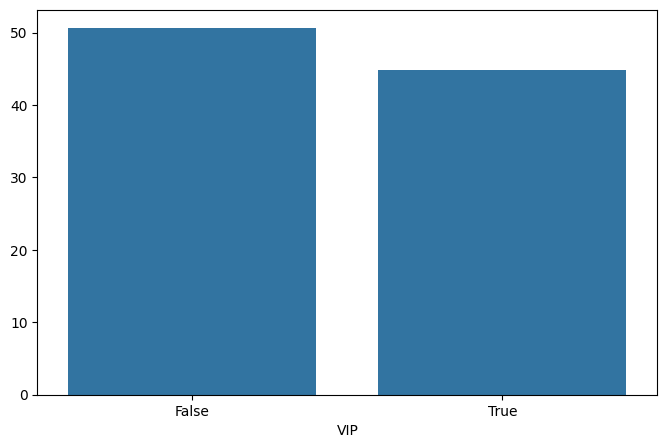

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S


In [155]:
survival_rate = train_df.groupby("VIP")["Transported"].mean() * 100

plt.figure(figsize=(8, 5))
sns.barplot(x = survival_rate.index, y=survival_rate.values)
plt.show()

train_df.head(5)

In [162]:
##### OneHotEncoding des valeurs catégorielles

cat_cols = ["HomePlanet", "Destination", "Deck", "Side"]
num_cols = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

X_train = preprocessor.fit_transform(train_df)
# Récupération des noms des features encodées
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)

# Combinaison des colonnes finales
final_columns = np.concatenate([encoded_cat_cols, num_cols])

# Transformation + création du DataFrame avec bons noms
X_train = pd.DataFrame(preprocessor.transform(train_df), columns=final_columns)

X_train.head()
#print(" Columns : ", X_train.columns)

,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_Unknown,Side_S,Side_Unknown,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,24.0,109.0,9.0,25.0,549.0,44.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,58.0,43.0,3576.0,0.0,6715.0,49.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,33.0,0.0,1283.0,371.0,3329.0,193.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,16.0,303.0,70.0,151.0,565.0,2.0
